In [2]:
# =========================================================
# PHASE-1 — STEP-1: Imports + Basic Config (EfficientNet-B4)
# =========================================================

import os
import random
from pathlib import Path
import numpy as np
import torch

# ------------------------------
# Dataset root (Kaggle input)
# ------------------------------
DATASET_ROOT = "/kaggle/input/chilli-datase-mendleev/Chili Leaf Disease Augmented Dataset"

# ------------------------------
# Class names (MUST match folder names exactly)
# ------------------------------
CLASSES = [
    "Bacterial Spot",
    "Cercospora Leaf Spot",
    "Curl Virus",
    "Healthy Leaf",
    "Nutrition Deficiency",
    "White spot",
]
NUM_CLASSES = len(CLASSES)

# ------------------------------
# Dedicated paths for Model-2 ONLY
# ------------------------------
SPLIT_ROOT = Path("/kaggle/working/chili_split_efficientnetb4")
CHECKPOINT_DIR = Path("/kaggle/working/efficientnetb4_checkpoints")

SPLIT_ROOT.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

print(" Split folder:", SPLIT_ROOT)
print(" Checkpoint folder:", CHECKPOINT_DIR)

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ------------------------------
# Device
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Device:", device)

# ------------------------------
# Sanity check dataset
# ------------------------------
print("Dataset folders:")
print(os.listdir(DATASET_ROOT))


 Split folder: /kaggle/working/chili_split_efficientnetb4
 Checkpoint folder: /kaggle/working/efficientnetb4_checkpoints
 Device: cuda
Dataset folders:
['White spot', 'Curl Virus', 'Healthy Leaf', 'Nutrition Deficiency', 'Bacterial Spot', 'Cercospora Leaf Spot']


In [3]:
# =========================================================
# PHASE-1 — STEP-2: Stratified Train / Val / Test Split
#                 (70% / 15% / 15%)
# =========================================================

import shutil
from sklearn.model_selection import train_test_split

# Create directory structure
for phase in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(SPLIT_ROOT / phase / cls, exist_ok=True)

print("Generating stratified split...")

for cls in CLASSES:
    img_dir = os.path.join(DATASET_ROOT, cls)
    images = os.listdir(img_dir)

    # 70% train, 30% temp
    train_imgs, temp_imgs = train_test_split(
        images,
        test_size=0.30,
        random_state=SEED
    )

    # 15% val, 15% test
    val_imgs, test_imgs = train_test_split(
        temp_imgs,
        test_size=0.50,
        random_state=SEED
    )

    for img in train_imgs:
        shutil.copy(
            os.path.join(img_dir, img),
            SPLIT_ROOT / "train" / cls / img
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(img_dir, img),
            SPLIT_ROOT / "val" / cls / img
        )

    for img in test_imgs:
        shutil.copy(
            os.path.join(img_dir, img),
            SPLIT_ROOT / "test" / cls / img
        )

print("Dataset successfully split into 70% train / 15% val / 15% test")
print("Split location:", SPLIT_ROOT)


Generating stratified split...
Dataset successfully split into 70% train / 15% val / 15% test
Split location: /kaggle/working/chili_split_efficientnetb4


In [4]:
# =========================================================
# PHASE-1 — STEP-3: Transforms, Dataset, Dataloaders
# =========================================================

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

# -------- Transforms --------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# -------- Dataset paths --------
train_dir = SPLIT_ROOT / "train"
val_dir   = SPLIT_ROOT / "val"
test_dir  = SPLIT_ROOT / "test"

# -------- Datasets --------
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset   = ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = ImageFolder(test_dir, transform=val_test_transform)

# -------- Dataloaders --------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("Dataloaders Ready")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches  : {len(val_loader)}")
print(f"Test batches : {len(test_loader)}")


Dataloaders Ready
Train batches: 263
Val batches  : 57
Test batches : 57


In [5]:
# =========================================================
# PHASE-2 — STEP-1: EfficientNet-B4 (Stage-1: Feature Extraction)
# =========================================================

import torch.nn as nn
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

# Number of classes
NUM_CLASSES = len(CLASSES)

# Load pretrained EfficientNet-B4
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)

# Freeze entire backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head (SAME pattern as previous models)
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, NUM_CLASSES)
)

model = model.to(device)

print("EfficientNet-B4 initialized for Stage-1 (feature extraction only).")
print(
    "Trainable parameters:",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
    "/",
    sum(p.numel() for p in model.parameters())
)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 181MB/s] 


EfficientNet-B4 initialized for Stage-1 (feature extraction only).
Trainable parameters: 10758 / 17559374


In [6]:
# =========================================================
# PHASE-2 — STEP-2: Stage-1 Training (EfficientNet-B4 Baseline)
# =========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

EPOCHS_STAGE1 = 5
best_val_acc_stage1 = 0.0
start_time = time.time()

for epoch in range(1, EPOCHS_STAGE1 + 1):
    model.train()
    train_correct = 0
    train_total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # ---------- Validation ----------
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(
        f"Stage-1 Epoch {epoch}/{EPOCHS_STAGE1} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc_stage1:
        best_val_acc_stage1 = val_acc
        torch.save(
            model.state_dict(),
            "/kaggle/working/efficientnet_b4_stage1_best.pth"
        )
        print("→ Best model updated.")

elapsed = (time.time() - start_time) / 60
print(f"\nStage-1 training complete in {elapsed:.2f} minutes.")
print(f"Best Stage-1 Validation Accuracy: {best_val_acc_stage1:.4f}")
print("Checkpoint saved → /kaggle/working/efficientnet_b4_stage1_best.pth")


Stage-1 Epoch 1/5 | Train Acc: 0.7926 | Val Acc: 0.9022
→ Best model updated.
Stage-1 Epoch 2/5 | Train Acc: 0.8796 | Val Acc: 0.9239
→ Best model updated.
Stage-1 Epoch 3/5 | Train Acc: 0.8970 | Val Acc: 0.9439
→ Best model updated.
Stage-1 Epoch 4/5 | Train Acc: 0.9058 | Val Acc: 0.9478
→ Best model updated.
Stage-1 Epoch 5/5 | Train Acc: 0.9183 | Val Acc: 0.9494
→ Best model updated.

Stage-1 training complete in 7.82 minutes.
Best Stage-1 Validation Accuracy: 0.9494
Checkpoint saved → /kaggle/working/efficientnet_b4_stage1_best.pth


In [7]:
# =========================================================
# PHASE-2 — STEP-3: Stage-2 Fine-Tuning (EfficientNet-B4)
# =========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import time

# -------- Load Stage-1 checkpoint --------
stage1_ckpt = "/kaggle/working/efficientnet_b4_stage1_best.pth"
model.load_state_dict(torch.load(stage1_ckpt, map_location=device))
print(f"Loaded Stage-1 checkpoint → {stage1_ckpt}")

# -------- Unfreeze entire model --------
for param in model.parameters():
    param.requires_grad = True

# -------- Optimizer (lower LR) --------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS_STAGE2 = 10
best_val_acc_stage2 = 0.0
start_time = time.time()

print("\nStarting Stage-2 Fine-Tuning...\n")

for epoch in range(1, EPOCHS_STAGE2 + 1):
    model.train()
    train_correct = 0
    train_total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # ---------- Validation ----------
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(
        f"Stage-2 Epoch {epoch}/{EPOCHS_STAGE2} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc_stage2:
        best_val_acc_stage2 = val_acc
        torch.save(
            model.state_dict(),
            "/kaggle/working/efficientnet_b4_baseline_best.pth"
        )
        print("→ Best model updated.")

elapsed = (time.time() - start_time) / 60
print(f"\nStage-2 fine-tuning complete in {elapsed:.2f} minutes.")
print(f"Best Stage-2 Validation Accuracy: {best_val_acc_stage2:.4f}")
print("Final baseline checkpoint saved → /kaggle/working/efficientnet_b4_baseline_best.pth")


Loaded Stage-1 checkpoint → /kaggle/working/efficientnet_b4_stage1_best.pth

Starting Stage-2 Fine-Tuning...

Stage-2 Epoch 1/10 | Train Acc: 0.9598 | Val Acc: 0.9856
→ Best model updated.
Stage-2 Epoch 2/10 | Train Acc: 0.9825 | Val Acc: 0.9906
→ Best model updated.
Stage-2 Epoch 3/10 | Train Acc: 0.9905 | Val Acc: 0.9917
→ Best model updated.
Stage-2 Epoch 4/10 | Train Acc: 0.9906 | Val Acc: 0.9928
→ Best model updated.
Stage-2 Epoch 5/10 | Train Acc: 0.9914 | Val Acc: 0.9933
→ Best model updated.
Stage-2 Epoch 6/10 | Train Acc: 0.9937 | Val Acc: 0.9933
Stage-2 Epoch 7/10 | Train Acc: 0.9935 | Val Acc: 0.9939
→ Best model updated.
Stage-2 Epoch 8/10 | Train Acc: 0.9943 | Val Acc: 0.9933
Stage-2 Epoch 9/10 | Train Acc: 0.9939 | Val Acc: 0.9933
Stage-2 Epoch 10/10 | Train Acc: 0.9935 | Val Acc: 0.9939

Stage-2 fine-tuning complete in 22.44 minutes.
Best Stage-2 Validation Accuracy: 0.9939
Final baseline checkpoint saved → /kaggle/working/efficientnet_b4_baseline_best.pth


Loaded EfficientNet-B4 Baseline Weights → /kaggle/working/efficientnet_b4_baseline_best.pth

Baseline Test Accuracy (EfficientNet-B4): 99.61%

Classification Report:

                      precision    recall  f1-score   support

      Bacterial Spot       0.98      1.00      0.99       300
Cercospora Leaf Spot       1.00      0.98      0.99       300
          Curl Virus       1.00      1.00      1.00       300
        Healthy Leaf       1.00      1.00      1.00       300
Nutrition Deficiency       1.00      1.00      1.00       300
          White spot       1.00      1.00      1.00       300

            accuracy                           1.00      1800
           macro avg       1.00      1.00      1.00      1800
        weighted avg       1.00      1.00      1.00      1800



,precision,recall,f1-score,support
Bacterial Spot,0.977199,1.000000,0.988468,300.000000
Cercospora Leaf Spot,1.000000,0.976667,0.988196,300.000000
Curl Virus,1.000000,1.000000,1.000000,300.000000
Healthy Leaf,1.000000,1.000000,1.000000,300.000000
Nutrition Deficiency,1.000000,1.000000,1.000000,300.000000
White spot,1.000000,1.000000,1.000000,300.000000
accuracy,0.996111,0.996111,0.996111,0.996111
macro avg,0.996200,0.996111,0.996111,1800.000000
weighted avg,0.996200,0.996111,0.996111,1800.000000


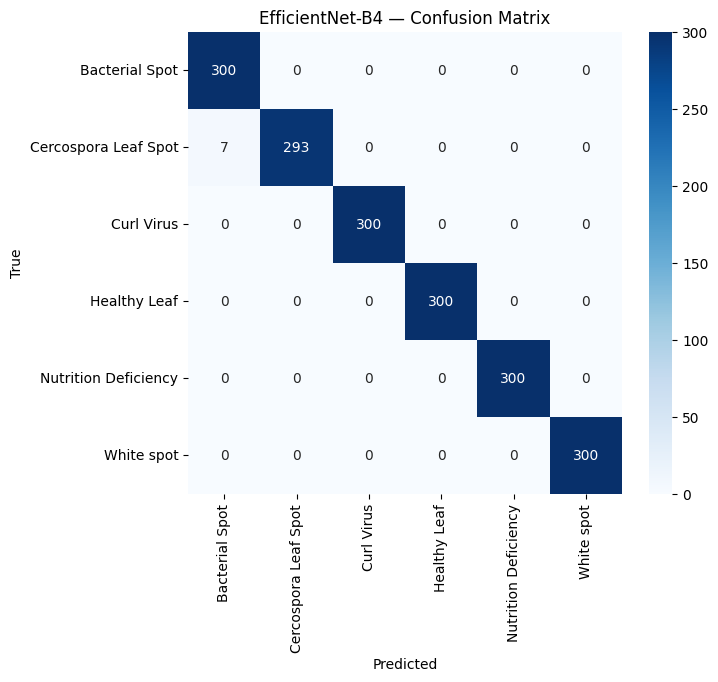

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


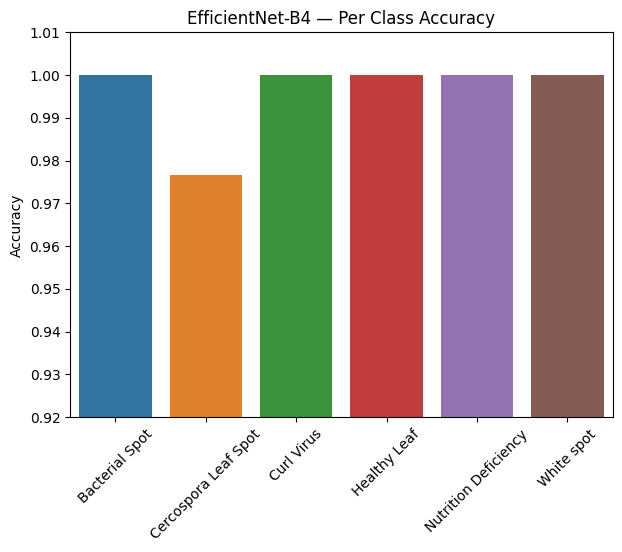

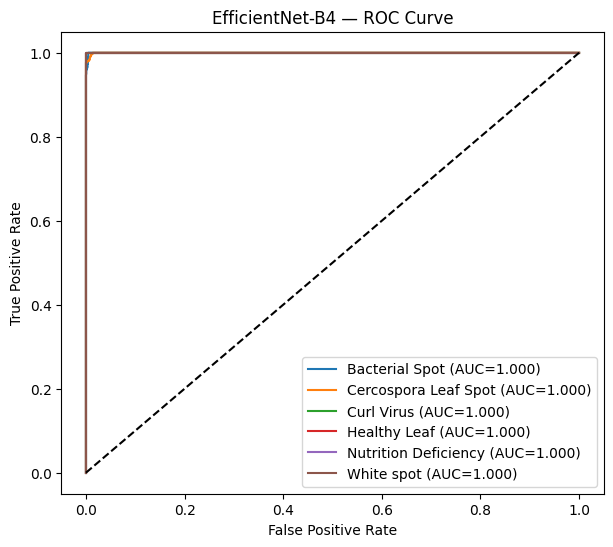

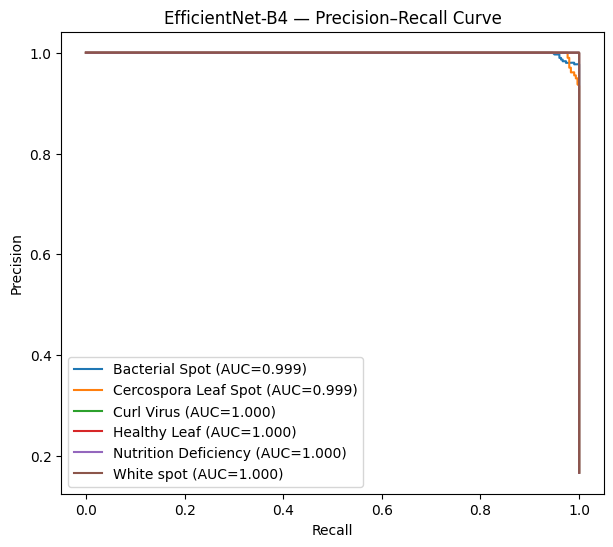

----- Final Summary Metrics -----
Test Accuracy     : 99.61%
Macro F1 Score    : 0.9961
Weighted F1 Score : 0.9961
Macro ROC-AUC     : 0.9999
Macro PR-AUC      : 0.9997
---------------------------------



In [11]:
# =========================================================
# PHASE-3 — TEST EVALUATION (EfficientNet-B4 Baseline Model)
# =========================================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, f1_score
)

from torchvision import models
import torch.nn as nn

# ---------------- Build model EXACTLY like training ----------------
model = models.efficientnet_b4(weights=None)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, NUM_CLASSES)
)

model = model.to(device)

# ---------------- Load Stage-2 Checkpoint ----------------
ckpt_path = "/kaggle/working/efficientnet_b4_baseline_best.pth"
state_dict = torch.load(ckpt_path, map_location=device)

model.load_state_dict(state_dict)
model.eval()

print(f"Loaded EfficientNet-B4 Baseline Weights → {ckpt_path}")

# ---------------- Start Evaluation ----------------
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

# ---------------- Accuracy ----------------
test_acc = (all_preds == all_labels).mean() * 100
print(f"\nBaseline Test Accuracy (EfficientNet-B4): {test_acc:.2f}%\n")

# ---------------- Classification Report ----------------
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=CLASSES))

df_report = pd.DataFrame(
    classification_report(
        all_labels,
        all_preds,
        target_names=CLASSES,
        output_dict=True
    )
).transpose()
display(df_report)

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientNet-B4 — Confusion Matrix")
plt.show()

# ---------------- Per-class Accuracy ----------------
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(7,5))
sns.barplot(x=CLASSES, y=class_acc)
plt.ylim(0.92, 1.01)
plt.title("EfficientNet-B4 — Per Class Accuracy")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.show()

# ---------------- ROC Curve ----------------
plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CLASSES[i]} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNet-B4 — ROC Curve")
plt.legend()
plt.show()

# ---------------- Precision–Recall Curve ----------------
plt.figure(figsize=(7,6))
pr_auc_list = []
for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_list.append(pr_auc)
    plt.plot(recall, precision, label=f"{CLASSES[i]} (AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("EfficientNet-B4 — Precision–Recall Curve")
plt.legend()
plt.show()

# ---------------- Final Summary Metrics ----------------
macro_f1       = f1_score(all_labels, all_preds, average="macro")
weighted_f1    = f1_score(all_labels, all_preds, average="weighted")
roc_auc_macro  = np.mean([
    auc(*roc_curve(all_labels == i, all_probs[:, i])[:2])
    for i in range(NUM_CLASSES)
])
pr_auc_macro   = np.mean(pr_auc_list)

print("----- Final Summary Metrics -----")
print(f"Test Accuracy     : {test_acc:.2f}%")
print(f"Macro F1 Score    : {macro_f1:.4f}")
print(f"Weighted F1 Score : {weighted_f1:.4f}")
print(f"Macro ROC-AUC     : {roc_auc_macro:.4f}")
print(f"Macro PR-AUC      : {pr_auc_macro:.4f}")
print("---------------------------------\n")


In [13]:
# ============================================
# PHASE-3 — HYPERPARAMETER TUNING (EfficientNet-B4)
# EXACT SAME workflow as DenseNet121
# ============================================

from torchvision import models
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import torch

# ---------------- HPT Configurations ----------------
HPT_CONFIGS = [
    {"lr": 1e-3, "dropout": 0.3, "fc_units": 256},
    {"lr": 1e-3, "dropout": 0.4, "fc_units": 256},
    {"lr": 1e-3, "dropout": 0.5, "fc_units": 512},
    {"lr": 5e-4, "dropout": 0.3, "fc_units": 256},
    {"lr": 5e-4, "dropout": 0.4, "fc_units": 512},
    {"lr": 5e-4, "dropout": 0.5, "fc_units": 512},
    {"lr": 3e-4, "dropout": 0.3, "fc_units": 384},
    {"lr": 3e-4, "dropout": 0.4, "fc_units": 512},
    {"lr": 3e-4, "dropout": 0.5, "fc_units": 640},
    {"lr": 1e-4, "dropout": 0.3, "fc_units": 512},
    {"lr": 1e-4, "dropout": 0.4, "fc_units": 640},
    {"lr": 1e-4, "dropout": 0.5, "fc_units": 768},
]

print("HPT configurations loaded:", len(HPT_CONFIGS))

results_hpt = []
best_cfg_hpt = None
best_val_acc_hpt = 0.0
best_model_state = None

criterion = nn.CrossEntropyLoss()

print(f"\n===== Running {len(HPT_CONFIGS)} HPT Trials for EfficientNet-B4 =====\n")

# ---------------- HPT Loop ----------------
for idx, cfg in enumerate(HPT_CONFIGS, 1):
    lr = cfg["lr"]
    dropout = cfg["dropout"]
    units = cfg["fc_units"]

    print(f"\n===== HPT TRIAL {idx}/{len(HPT_CONFIGS)} | lr={lr} dropout={dropout} units={units} =====")

    # ---------------- Build EfficientNet-B4 ----------------
    model_hpt = models.efficientnet_b4(weights="IMAGENET1K_V1")

    # Freeze backbone (Stage-1)
    for p in model_hpt.parameters():
        p.requires_grad = False

    in_features = model_hpt.classifier[1].in_features

    # EXACT SAME classifier architecture as DenseNet121
    model_hpt.classifier = nn.Sequential(
        nn.Linear(in_features, units),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(units, NUM_CLASSES)
    )

    model_hpt = model_hpt.to(device)
    optimizer = optim.Adam(model_hpt.classifier.parameters(), lr=lr)

    # ---------------- Stage-1 Training ----------------
    EPOCHS_STAGE1 = 4
    best_val_trial = 0.0

    for epoch in range(1, EPOCHS_STAGE1 + 1):
        model_hpt.train()
        train_correct = 0
        train_total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_hpt(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total

        # ---------- Validation ----------
        model_hpt.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model_hpt(imgs).argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(
            f"  Stage-1 Epoch {epoch}/{EPOCHS_STAGE1} | "
            f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )

        best_val_trial = max(best_val_trial, val_acc)

    results_hpt.append({
        "lr": lr,
        "dropout": dropout,
        "fc_units": units,
        "val_acc": best_val_trial
    })

    if best_val_trial > best_val_acc_hpt:
        best_val_acc_hpt = best_val_trial
        best_cfg_hpt = deepcopy(cfg)
        best_model_state = deepcopy(model_hpt.state_dict())

    torch.cuda.empty_cache()

# ---------------- Results ----------------
results_hpt_sorted = sorted(results_hpt, key=lambda x: x["val_acc"], reverse=True)

print("\n===== HPT RESULTS (BEST → WORST) — EfficientNet-B4 =====")
for r in results_hpt_sorted:
    print(r)

print("\n===== BEST CONFIGURATION — Stage-1 HPT =====")
print(best_cfg_hpt)
print(f"Best Stage-1 Validation Accuracy: {best_val_acc_hpt:.4f}")

# ---------------- Save Best Stage-1 Model ----------------
best_hpt_stage1_path = "/kaggle/working/efficientnet_b4_hpt_stage1_best.pth"
torch.save(best_model_state, best_hpt_stage1_path)
print(f"\nCheckpoint saved: {best_hpt_stage1_path}")


HPT configurations loaded: 12

===== Running 12 HPT Trials for EfficientNet-B4 =====


===== HPT TRIAL 1/12 | lr=0.001 dropout=0.3 units=256 =====
  Stage-1 Epoch 1/4 | Train Acc: 0.8437 | Val Acc: 0.9500
  Stage-1 Epoch 2/4 | Train Acc: 0.9250 | Val Acc: 0.9611
  Stage-1 Epoch 3/4 | Train Acc: 0.9423 | Val Acc: 0.9700
  Stage-1 Epoch 4/4 | Train Acc: 0.9446 | Val Acc: 0.9744

===== HPT TRIAL 2/12 | lr=0.001 dropout=0.4 units=256 =====
  Stage-1 Epoch 1/4 | Train Acc: 0.8405 | Val Acc: 0.9467
  Stage-1 Epoch 2/4 | Train Acc: 0.9187 | Val Acc: 0.9661
  Stage-1 Epoch 3/4 | Train Acc: 0.9367 | Val Acc: 0.9672
  Stage-1 Epoch 4/4 | Train Acc: 0.9406 | Val Acc: 0.9744

===== HPT TRIAL 3/12 | lr=0.001 dropout=0.5 units=512 =====
  Stage-1 Epoch 1/4 | Train Acc: 0.8433 | Val Acc: 0.9550
  Stage-1 Epoch 2/4 | Train Acc: 0.9226 | Val Acc: 0.9628
  Stage-1 Epoch 3/4 | Train Acc: 0.9374 | Val Acc: 0.9672
  Stage-1 Epoch 4/4 | Train Acc: 0.9438 | Val Acc: 0.9750

===== HPT TRIAL 4/12 | lr=0.0005 d

In [14]:
# =========================================================
# PHASE-3 — STEP-2: HPT Stage-2 Fine-Tuning (EfficientNet-B4)
# =========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models

# -------- Build model EXACTLY like HPT Stage-1 --------
model = models.efficientnet_b4(weights="IMAGENET1K_V1")

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

# -------- Load best HPT Stage-1 weights --------
stage1_ckpt = "/kaggle/working/efficientnet_b4_hpt_stage1_best.pth"
model.load_state_dict(torch.load(stage1_ckpt, map_location=device))

print(f"Loaded Stage-1 HPT checkpoint → {stage1_ckpt}")

# -------- Unfreeze entire model --------
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -------- Stage-2 Training --------
EPOCHS_STAGE2 = 8
best_val_acc = 0.0
start_time = time.time()

print("\nStarting Stage-2 Fine-Tuning...\n")

for epoch in range(1, EPOCHS_STAGE2 + 1):
    model.train()
    train_correct, train_total = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # -------- Validation --------
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(
        f"Stage-2 Epoch {epoch}/{EPOCHS_STAGE2} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            model.state_dict(),
            "/kaggle/working/efficientnet_b4_hpt_best.pth"
        )
        print("→ Best model updated.")

elapsed = (time.time() - start_time) / 60
print(f"\nHPT Stage-2 Fine-Tuning complete in {elapsed:.2f} minutes.")
print(f"Best Validation Accuracy (HPT Stage-2): {best_val_acc:.4f}")
print("Final HPT checkpoint saved → /kaggle/working/efficientnet_b4_hpt_best.pth")


Loaded Stage-1 HPT checkpoint → /kaggle/working/efficientnet_b4_hpt_stage1_best.pth

Starting Stage-2 Fine-Tuning...

Stage-2 Epoch 1/8 | Train Acc: 0.9712 | Val Acc: 0.9900
→ Best model updated.
Stage-2 Epoch 2/8 | Train Acc: 0.9850 | Val Acc: 0.9906
→ Best model updated.
Stage-2 Epoch 3/8 | Train Acc: 0.9894 | Val Acc: 0.9922
→ Best model updated.
Stage-2 Epoch 4/8 | Train Acc: 0.9910 | Val Acc: 0.9933
→ Best model updated.
Stage-2 Epoch 5/8 | Train Acc: 0.9910 | Val Acc: 0.9939
→ Best model updated.
Stage-2 Epoch 6/8 | Train Acc: 0.9921 | Val Acc: 0.9917
Stage-2 Epoch 7/8 | Train Acc: 0.9926 | Val Acc: 0.9933
Stage-2 Epoch 8/8 | Train Acc: 0.9944 | Val Acc: 0.9917

HPT Stage-2 Fine-Tuning complete in 18.05 minutes.
Best Validation Accuracy (HPT Stage-2): 0.9939
Final HPT checkpoint saved → /kaggle/working/efficientnet_b4_hpt_best.pth


Loaded EfficientNet-B4 HPT Weights → /kaggle/working/efficientnet_b4_hpt_best.pth

HPT Test Accuracy (EfficientNet-B4): 99.50%

Classification Report:

                      precision    recall  f1-score   support

      Bacterial Spot       0.98      1.00      0.99       300
Cercospora Leaf Spot       1.00      0.98      0.99       300
          Curl Virus       1.00      1.00      1.00       300
        Healthy Leaf       1.00      1.00      1.00       300
Nutrition Deficiency       1.00      1.00      1.00       300
          White spot       1.00      1.00      1.00       300

            accuracy                           0.99      1800
           macro avg       1.00      1.00      0.99      1800
        weighted avg       1.00      0.99      0.99      1800



,precision,recall,f1-score,support
Bacterial Spot,0.977124,0.996667,0.986799,300.000
Cercospora Leaf Spot,0.996599,0.976667,0.986532,300.000
Curl Virus,1.000000,1.000000,1.000000,300.000
Healthy Leaf,1.000000,0.996667,0.998331,300.000
Nutrition Deficiency,1.000000,1.000000,1.000000,300.000
White spot,0.996678,1.000000,0.998336,300.000
accuracy,0.995000,0.995000,0.995000,0.995
macro avg,0.995067,0.995000,0.995000,1800.000
weighted avg,0.995067,0.995000,0.995000,1800.000


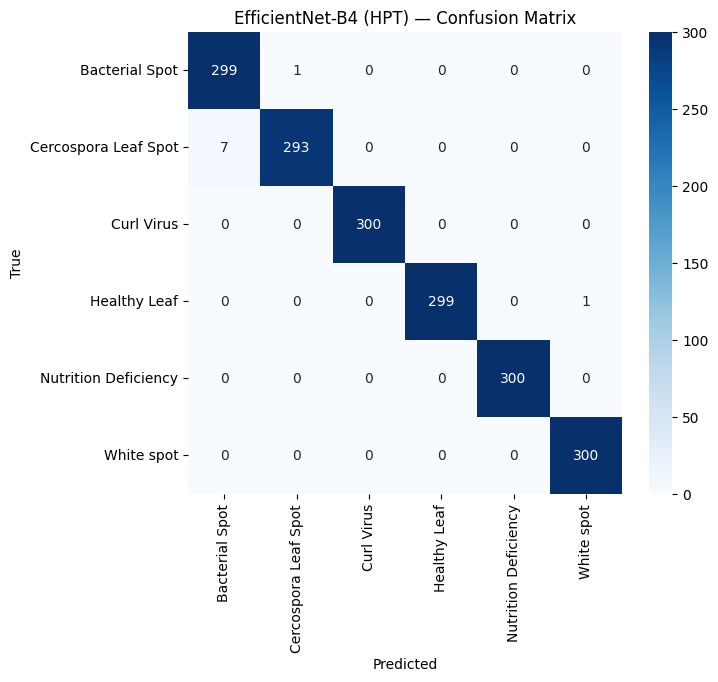

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


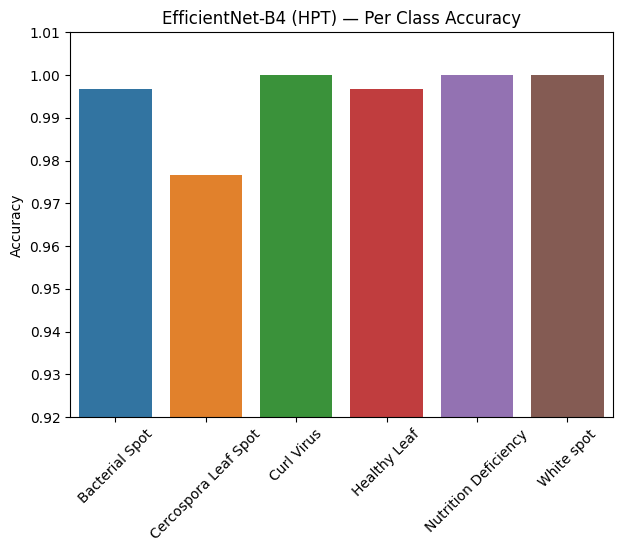

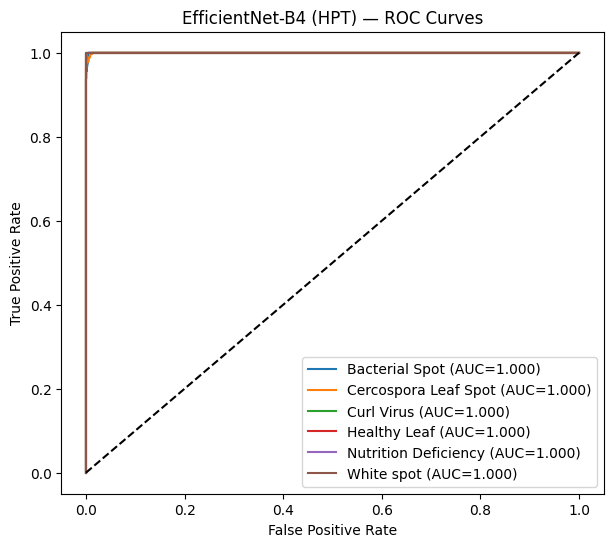

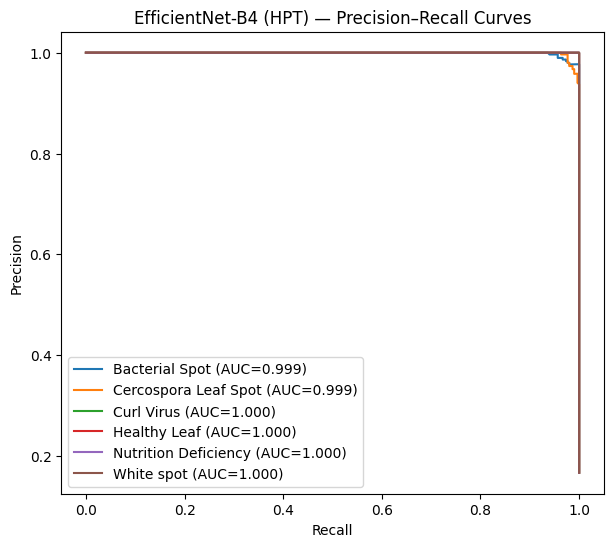

----- Final Summary Metrics -----
Test Accuracy     : 99.50%
Macro F1 Score    : 0.9950
Weighted F1 Score : 0.9950
Macro ROC-AUC     : 0.9999
Macro PR-AUC      : 0.9997
---------------------------------


In [17]:
# =========================================================
# PHASE-3 — TEST EVALUATION (EfficientNet-B4 HPT Model)
# =========================================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, f1_score
)

from torchvision.models import efficientnet_b4
import torch.nn as nn

# ---------------- Build model EXACTLY like HPT training ----------------
model = efficientnet_b4(weights=None)

in_features = model.classifier[1].in_features

# 🔒 MUST MATCH BEST HPT CONFIG
BEST_FC_UNITS = 512
BEST_DROPOUT  = 0.5

model.classifier = nn.Sequential(
    nn.Linear(in_features, BEST_FC_UNITS),
    nn.ReLU(),
    nn.Dropout(BEST_DROPOUT),
    nn.Linear(BEST_FC_UNITS, NUM_CLASSES)
)

model = model.to(device)

# ---------------- Load HPT Stage-2 checkpoint ----------------
ckpt_path = "/kaggle/working/efficientnet_b4_hpt_best.pth"
state_dict = torch.load(ckpt_path, map_location=device)

model.load_state_dict(state_dict)   # ✅ GUARANTEED TO LOAD
model.eval()

print(f"Loaded EfficientNet-B4 HPT Weights → {ckpt_path}")

# ---------------- Inference ----------------
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

# ---------------- Accuracy ----------------
test_acc = (all_preds == all_labels).mean() * 100
print(f"\nHPT Test Accuracy (EfficientNet-B4): {test_acc:.2f}%\n")

# ---------------- Classification Report ----------------
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=CLASSES))

df_report = pd.DataFrame(
    classification_report(all_labels, all_preds, target_names=CLASSES, output_dict=True)
).transpose()
display(df_report)

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=CLASSES, yticklabels=CLASSES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientNet-B4 (HPT) — Confusion Matrix")
plt.show()

# ---------------- Per-class Accuracy ----------------
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(7,5))
sns.barplot(x=CLASSES, y=class_acc)
plt.ylim(0.92, 1.01)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("EfficientNet-B4 (HPT) — Per Class Accuracy")
plt.show()

# ---------------- ROC Curves ----------------
plt.figure(figsize=(7,6))
roc_auc_list = []

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
    auc_score = auc(fpr, tpr)
    roc_auc_list.append(auc_score)
    plt.plot(fpr, tpr, label=f"{CLASSES[i]} (AUC={auc_score:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNet-B4 (HPT) — ROC Curves")
plt.legend()
plt.show()

# ---------------- Precision–Recall Curves ----------------
plt.figure(figsize=(7,6))
pr_auc_list = []

for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_list.append(pr_auc)
    plt.plot(recall, precision, label=f"{CLASSES[i]} (AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("EfficientNet-B4 (HPT) — Precision–Recall Curves")
plt.legend()
plt.show()

# ---------------- Final Summary Metrics ----------------
macro_f1       = f1_score(all_labels, all_preds, average="macro")
weighted_f1    = f1_score(all_labels, all_preds, average="weighted")
roc_auc_macro  = np.mean(roc_auc_list)
pr_auc_macro   = np.mean(pr_auc_list)

print("----- Final Summary Metrics -----")
print(f"Test Accuracy     : {test_acc:.2f}%")
print(f"Macro F1 Score    : {macro_f1:.4f}")
print(f"Weighted F1 Score : {weighted_f1:.4f}")
print(f"Macro ROC-AUC     : {roc_auc_macro:.4f}")
print(f"Macro PR-AUC      : {pr_auc_macro:.4f}")
print("---------------------------------")


,Metric,Baseline,Tuned (HPT),Difference (HPT - Baseline)
0,Test Accuracy (%),99.6100,99.5000,-0.1100
1,Macro F1 Score,0.9961,0.9950,-0.0011
2,Weighted F1 Score,0.9961,0.9950,-0.0011
3,Macro ROC-AUC,0.9999,0.9999,0.0000
4,Macro PR-AUC,0.9997,0.9997,0.0000


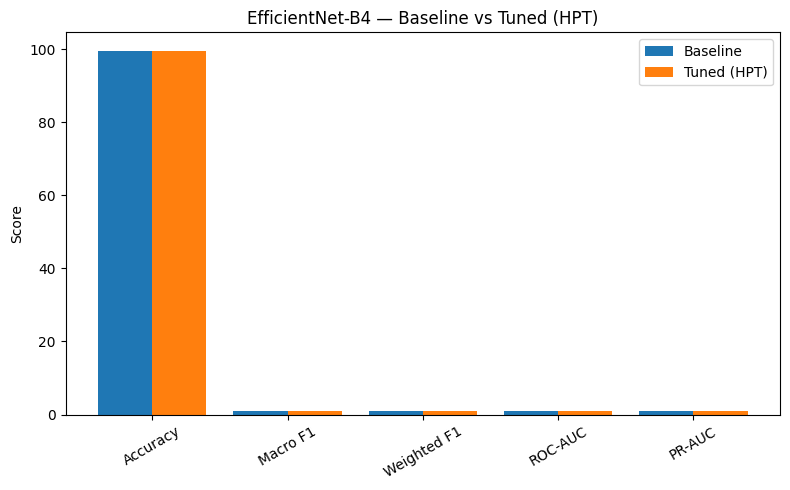


Conclusion:


For EfficientNet-B4, the baseline model slightly outperformed the tuned (HPT) model
in terms of test accuracy and F1 scores. Both models achieved near-saturation
performance on the dataset, with Macro ROC-AUC and PR-AUC values remaining almost
identical. This indicates that EfficientNet-B4 is already highly optimized in its
baseline configuration for this task, and additional hyperparameter tuning does not
guarantee further performance gains. The baseline EfficientNet-B4 can therefore be
considered more stable and computationally efficient for deployment.



In [18]:
# =========================================================
# PHASE-4 — BASELINE vs HPT COMPARISON (EfficientNet-B4)
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt

# =======================
# Metrics (from evaluation outputs)
# =======================

baseline_test_acc    = 99.61
baseline_macro_f1    = 0.9961
baseline_weighted_f1 = 0.9961
baseline_roc_auc     = 0.9999
baseline_pr_auc      = 0.9997

hpt_test_acc         = 99.50
hpt_macro_f1         = 0.9950
hpt_weighted_f1      = 0.9950
hpt_roc_auc          = 0.9999
hpt_pr_auc           = 0.9997

# =======================
# Pandas Summary Table
# =======================

summary = {
    "Metric": [
        "Test Accuracy (%)",
        "Macro F1 Score",
        "Weighted F1 Score",
        "Macro ROC-AUC",
        "Macro PR-AUC"
    ],
    "Baseline": [
        baseline_test_acc,
        baseline_macro_f1,
        baseline_weighted_f1,
        baseline_roc_auc,
        baseline_pr_auc
    ],
    "Tuned (HPT)": [
        hpt_test_acc,
        hpt_macro_f1,
        hpt_weighted_f1,
        hpt_roc_auc,
        hpt_pr_auc
    ],
    "Difference (HPT - Baseline)": [
        hpt_test_acc - baseline_test_acc,
        hpt_macro_f1 - baseline_macro_f1,
        hpt_weighted_f1 - baseline_weighted_f1,
        hpt_roc_auc - baseline_roc_auc,
        hpt_pr_auc - baseline_pr_auc
    ]
}

df_summary = pd.DataFrame(summary)
display(df_summary)

# =======================
# Bar Chart Comparison
# =======================

metrics = ["Accuracy", "Macro F1", "Weighted F1", "ROC-AUC", "PR-AUC"]
baseline_vals = [
    baseline_test_acc,
    baseline_macro_f1,
    baseline_weighted_f1,
    baseline_roc_auc,
    baseline_pr_auc
]
hpt_vals = [
    hpt_test_acc,
    hpt_macro_f1,
    hpt_weighted_f1,
    hpt_roc_auc,
    hpt_pr_auc
]

plt.figure(figsize=(8,5))
x = range(len(metrics))

plt.bar([i - 0.2 for i in x], baseline_vals, width=0.4, label="Baseline")
plt.bar([i + 0.2 for i in x], hpt_vals, width=0.4, label="Tuned (HPT)")

plt.xticks(x, metrics, rotation=30)
plt.ylabel("Score")
plt.title("EfficientNet-B4 — Baseline vs Tuned (HPT)")
plt.legend()
plt.tight_layout()
plt.show()

# =======================
# Conclusion Text
# =======================

conclusion_text = """
For EfficientNet-B4, the baseline model slightly outperformed the tuned (HPT) model
in terms of test accuracy and F1 scores. Both models achieved near-saturation
performance on the dataset, with Macro ROC-AUC and PR-AUC values remaining almost
identical. This indicates that EfficientNet-B4 is already highly optimized in its
baseline configuration for this task, and additional hyperparameter tuning does not
guarantee further performance gains. The baseline EfficientNet-B4 can therefore be
considered more stable and computationally efficient for deployment.
"""

print("\nConclusion:\n")
print(conclusion_text)
